# Interpretation of individual predictions with Local-DIFFI

In this notebook are reproduced the experimental results on the Local-DIFFI method described in our paper [Interpretable Anomaly Detection with DIFFI: Depth-based Feature Importance for the Isolation Forest](https://arxiv.org/pdf/2007.11117.pdf).

The present code represents the very first release of the DIFFI algorithm: the code in this version is not yet optimized.

In [1]:
import os
import numpy as np
import pickle as pkl 
import time
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import shap
import DIFFI.interpretability_module as interp
from DIFFI.utils import *

import data_processing as dp
from datetime import datetime


/Users/elnur/Desktop/Master_thesis/anomaly_detection_for_shared_mobility/adbike_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
bike_weather_data = dp.process_data(city_name = 'boston', start = datetime(2023, 1, 1), end = datetime(2023, 1, 31), pca=False)


Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326



In [3]:
X = bike_weather_data.drop(columns=['special_day', 'route', 'start_geometry', 'end_geometry', 'start station id', 'end station id'])


In [4]:
# drop the month related columns as we are considering only January data
X = X.drop(columns=['end_month', 'start_month'])

## Train Isolation Forest

In [5]:
iforest = IsolationForest(n_estimators= 500, max_samples=1024, contamination='auto', random_state=0)
iforest.fit(X)
y_pred = np.array(iforest.decision_function(X) < 0).astype('int')


In [6]:
# it is X.columns[sorted_idx] in the unsupervised_fs.ipynb, features sorted by global DIFFI score
sorted_feature_names = ['tripduration', 'prcp', 'distance', 'speed', 'coco', 'route_area',
       'start_hour', 'end_hour', 'temp', 'wspd', 'start_neighborhood',
       'end_neighborhood', 'start_dayofweek', 'end_dayofweek',
       'user_type_encoded', 'end_nearby_transit_stops',
       'start_nearby_transit_stops']


## Get interpretations for anomalies

### Local-DIFFI

In [7]:
# Local-DIFFI
diffi_te, ord_idx_diffi_te, exec_time_diffi_te = local_diffi_batch(iforest, X.iloc[y_pred == 1][:100])
print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_te),3)))

Average computational time Local-DIFFI: 0.297


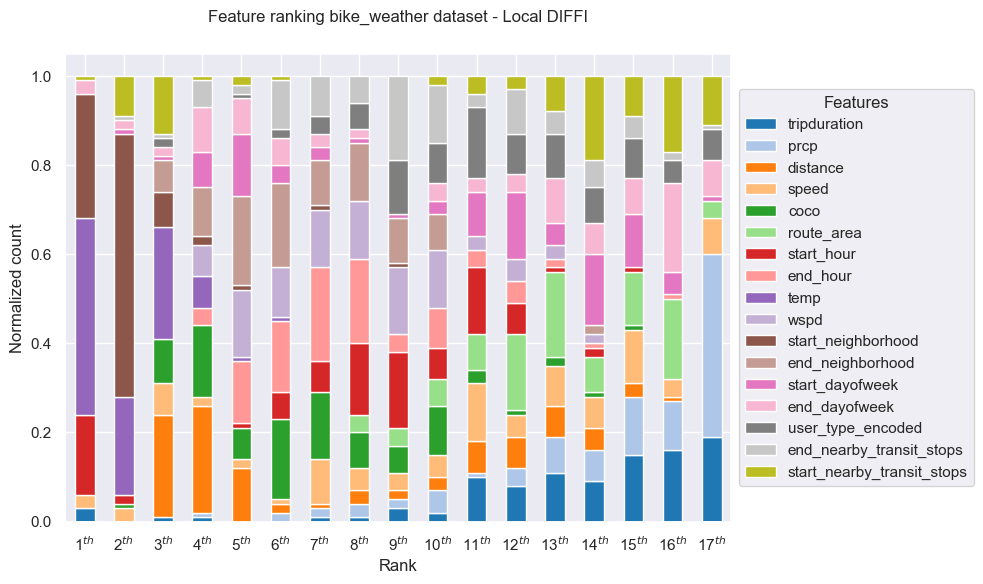

In [8]:
plot_feature_ranking(ord_idx_diffi_te, title = 'Feature ranking bike_weather dataset - Local DIFFI', sorted_feature_names = sorted_feature_names)

In [9]:
X.iloc[y_pred == 1][:100]

,tripduration,distance,user_type_encoded,speed,temp,wspd,prcp,coco,start_hour,start_dayofweek,end_hour,end_dayofweek,start_nearby_transit_stops,end_nearby_transit_stops,start_neighborhood,end_neighborhood,route_area
0,250,0.464383,1,6.687112,11.1,13.0,1.2,7.0,0,6,0,6,1,1,2,2,1
1,489,0.970031,0,7.141336,11.1,13.0,1.2,7.0,0,6,0,6,1,1,2,26,1
2,461,0.970031,0,7.575083,11.1,13.0,1.2,7.0,0,6,0,6,1,1,2,26,1
3,1065,0.585427,0,1.978907,11.1,13.0,1.2,7.0,0,6,0,6,0,1,4,11,1
4,601,1.136817,1,6.809552,11.1,13.0,1.2,7.0,0,6,0,6,1,2,2,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,751,2.612814,0,12.524810,11.1,11.2,0.3,7.0,1,6,1,6,2,1,11,26,1
96,1098,2.289213,1,7.505617,11.1,11.2,0.3,7.0,1,6,1,6,1,1,11,27,1
97,1776,4.448371,0,9.016968,11.1,11.2,0.3,7.0,1,6,1,6,1,2,27,14,1
98,600,2.402869,0,14.417216,11.1,11.2,0.3,7.0,1,6,1,6,0,2,1,37,2


### SHAP

In [10]:
# SHAP
shap_te, ord_idx_shap_te, exec_time_shap_te = local_shap_batch(iforest, X.iloc[y_pred == 1][:100])
print('Average computational time SHAP: {}'.format(round(np.mean(exec_time_shap_te),3)))

Average computational time SHAP: 6.061


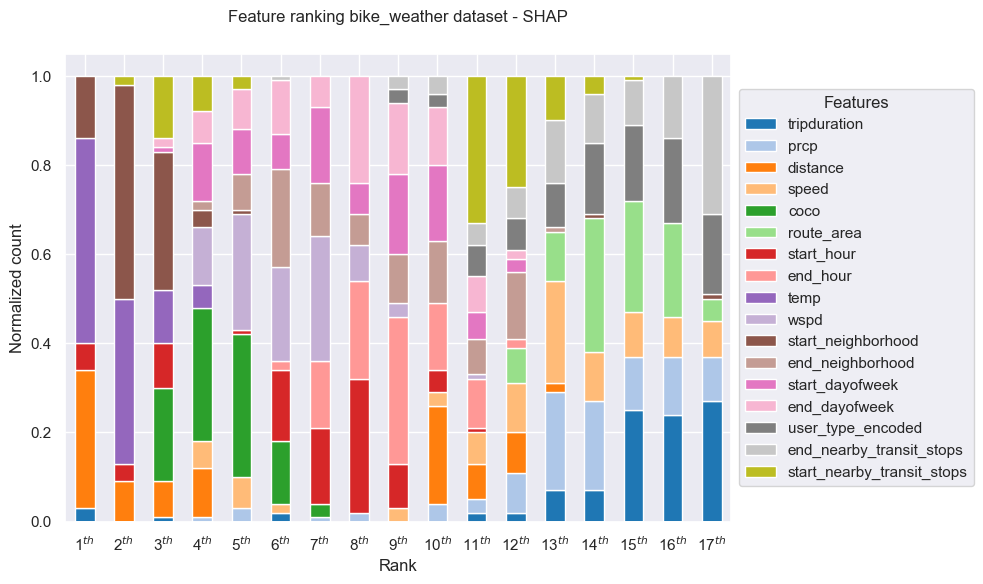

In [11]:
plot_feature_ranking(ord_idx_shap_te, title = 'Feature ranking bike_weather dataset - SHAP', sorted_feature_names = sorted_feature_names)